# Benchmarking new PICS implementation

The objective of this notebook is to compare the new implementation of PICS estimated on GWAS Catalog associations using gnomAD LD reference, against the previous implementation using 1000 genomes phase III LD reference. 

1. Describe the new dataset
    - Number of signals covered.
    - Number of signals dropped.
2. Copare with old PICS Dataset.
    - Δ number of covered study (not particularly relevant given updates in GWAS Catalog)
    - Δ number of covered peaks from studies found in the old release - might see increased coverage.
    - Δ in the recovered credible set: number of variants, change in posterior probability.
    - Δ in the average number of credible sets.

    

In [5]:
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()

## 1 Describing the new dataset

1. Study count.
2. Association count.
3. Studies split.
4. Associations not resolved in LD set.

In [14]:
new_study_locus = (
    spark.read.parquet("gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/pics_credible_set/")
    .withColumn("pics_99_perc_credset", f.when(f.col("tagVariantId").isNull(), False).otherwise(f.col("pics_99_perc_credset")))
    .withColumn(
        "hasResolvedCredibleSet",
        f.when(
            f.array_contains(
                f.collect_set(f.col("pics_99_perc_credset")).over(Window.partitionBy("studyId", "variantId")),
                True
            ),
            True
        ).otherwise(False)
    )
    .persist()
)


new_study_locus.printSchema()
new_study_locus.show(1, False, True)

root
 |-- chromosome: string (nullable = true)
 |-- variantId: string (nullable = true)
 |-- studyId: string (nullable = true)
 |-- position: string (nullable = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAllele: string (nullable = true)
 |-- pValueMantissa: float (nullable = true)
 |-- pValueExponent: integer (nullable = true)
 |-- beta: string (nullable = true)
 |-- beta_ci_lower: double (nullable = true)
 |-- beta_ci_upper: double (nullable = true)
 |-- odds_ratio: string (nullable = true)
 |-- odds_ratio_ci_lower: double (nullable = true)
 |-- odds_ratio_ci_upper: double (nullable = true)
 |-- qualityControl: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sampleSize: double (nullable = true)
 |-- tagVariantId: string (nullable = true)
 |-- R_overall: double (nullable = true)
 |-- pics_mu: double (nullable = true)
 |-- pics_std: double (nullable = true)
 |-- pics_postprob: double (nullable = true)
 |-- pics_95_perc_credset: boolea

-RECORD 0------------------------------------------
 chromosome             | 6                        
 variantId              | 6_13215826_A_G           
 studyId                | GCST000101_1             
 position               | 13215826                 
 referenceAllele        | A                        
 alternateAllele        | G                        
 pValueMantissa         | 3.0                      
 pValueExponent         | -6                       
 beta                   | null                     
 beta_ci_lower          | null                     
 beta_ci_upper          | null                     
 odds_ratio             | null                     
 odds_ratio_ci_lower    | null                     
 odds_ratio_ci_upper    | null                     
 qualityControl         | [Subsignificant p-value] 
 sampleSize             | 1094.0                   
 tagVariantId           | 6_13215826_A_G           
 R_overall              | 1.0                      
 pics_mu    

In [19]:
study_count = new_study_locus.select("studyId").distinct().count()
association_count = new_study_locus.select("studyId", "variantId").distinct().count()
association_w_credible_set = new_study_locus.filter(f.col("hasResolvedCredibleSet")).persist()
credible_set_count = association_w_credible_set.select("studyId", "variantId").distinct().count()
failed_w_ld = (
    new_study_locus
    # Selecting good associations without credible sets:
    .filter(
        (~f.col("hasResolvedCredibleSet")) &
        (f.size(f.col("qualityControl"))>0)
    )
    # Get associations:
    .select("studyId", "variantId")
    .distinct()
    .count()
)
good_association_count = (
    association_w_credible_set
    # Drop failed associations:
    .filter(f.size(f.col("qualityControl")) == 0)
    .select("studyId", "variantId")
    .distinct()
    .count()
)



22/12/19 11:45:49 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


Study count: 35956
Association (unique study/variant pairs) count: 433108
Associations with resolved credible set: 381056 (88.0%)
Number of good (non-flagged) associations without resolved credible set: 39763 (9.2%)
Number of good (non-flagged) associations with resolved credible set: 260736 (60.2%)


Focusing only on the actual credible sets.

In [22]:
# Thu
credible_sets = new_study_locus.filter(f.col("pics_99_perc_credset")).persist()
resolved_assoc_count = credible_sets.select("studyId", "variantId").distinct().count()
resolved_study_count = credible_sets.select("studyId").distinct().count()
lead_tag_pair_count = credible_sets.select("studyId", "variantId", "tagVariantId").distinct().count()

grouped_credset_pdf = credible_sets.groupBy("studyId", "variantId").count().toPandas()




22/12/19 11:57:56 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


Number of resolved credible sets: 381056
Studies with resolved credible sets: 33723
Number of lead/tag pairs: 18722043


<AxesSubplot:>

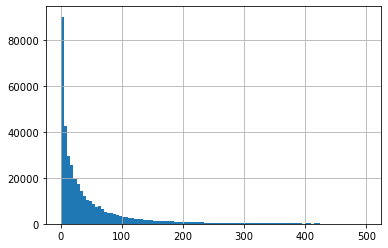

In [31]:
grouped_credset_pdf.query("count < 500")["count"].hist(bins=100)

In [45]:
median_credset_size = grouped_credset_pdf["count"].median()
credsets_with_single = len(grouped_credset_pdf.query("count == 1"))


Credible sets with only one variant: 29536 (7.8)%
Median size of credible sets: 21.0


In [41]:
credible_sets.groupBy("studyId", "variantId").count().filter(f.col("count") > 1000).orderBy("count", ascending=False).show(30)

+------------+---------------+-----+
|     studyId|      variantId|count|
+------------+---------------+-----+
|GCST90095125|17_46142465_T_A|11930|
|GCST90095124|17_46142465_T_A|11221|
|GCST006483_1|17_45608332_A_G| 9666|
|  GCST011766|17_45846834_C_G| 9566|
|GCST006481_2|17_45608332_A_G| 9445|
|GCST006483_1|17_45605039_C_G| 8912|
|GCST006483_3|17_45605039_C_G| 8602|
|GCST006481_4|17_45605039_C_G| 8545|
|GCST006483_1|17_46770468_T_G| 7465|
|GCST006481_2|17_46770468_T_G| 7396|
|GCST006483_3|17_46770468_T_G| 7374|
|GCST006481_4|17_46770468_T_G| 7327|
|GCST001651_9|17_46257341_G_A| 6926|
|GCST90134596|17_45707983_T_C| 6748|
|  GCST012099|17_45610951_A_G| 6603|
|GCST90104034|17_46152620_T_C| 6545|
|  GCST012101|17_45610951_A_G| 6374|
|GCST90134597|17_45707983_T_C| 6372|
|  GCST007692|17_45846834_C_G| 6331|
|GCST90013445|17_45996523_A_G| 5668|
|GCST008675_1|17_45733530_C_T| 5196|
|GCST004008_1|17_45749271_G_A| 5101|
|GCST006483_1|17_46785767_T_C| 4913|
|GCST006481_2|17_46785767_T_C| 4880|
|

## Comparing with old dataset

- Data: `gs://genetics-portal-dev-staging/v2d/220210/ld.parquet`

In [52]:
old_study_locus = (
    spark.read.parquet("gs://genetics-portal-dev-staging/v2d/220210/ld.parquet")
    .select(
        f.col("study_id").alias("studyId"),
        f.concat_ws("_", f.col("lead_chrom"), f.col("lead_pos"), f.col("lead_ref"), f.col("lead_alt")).alias("variantId"),
        f.concat_ws("_", f.col("tag_chrom"), f.col("tag_pos"), f.col("tag_ref"), f.col("tag_alt")).alias("tagVariantId"),
        "pics_postprob",
        "pics_95perc_credset",
        "pics_99perc_credset"
    )
    .distinct()
)
lead_tag_pair_count = old_study_locus.count()
study_count = old_study_locus.select("studyId").distinct().count()
association_count = old_study_locus.select("studyId", "variantId").distinct().count()



Number of lead/tag count: 19406519
NUmber of studies covered: 18349
Number of associations covered: 265715


In [57]:
tag_count = old_study_locus.groupBy("studyId", "variantId").count().persist()
median_tag_count = tag_count.toPandas()["count"].median()
single_count = tag_count.filter(f.col("count") == 1).count()
over_1000 = tag_count.filter(f.col("count") >= 1000).count()


tag_count.orderBy("count",ascending=False).show(20)

22/12/19 13:53:16 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


The median number of tag size: 21.0
Number of associations with single credible set: 9231
Number of associations with more than 1000 tags set: 441
+-------------+---------------+-----+
|      studyId|      variantId|count|
+-------------+---------------+-----+
|   GCST001482|17_45900461_C_T| 3685|
| GCST90018953|17_45856424_G_T| 3684|
|   GCST007692|17_45846834_C_G| 3649|
| GCST90018960|17_45761354_C_T| 3360|
| GCST90018996|17_46112544_A_G| 3348|
| GCST90091060|17_45873075_C_A| 3295|
|   GCST002970|17_45846317_A_G| 3294|
|   GCST001548|17_45846853_T_C| 3294|
|   GCST007328|17_45887201_A_C| 3294|
|   GCST007430|17_45887201_A_C| 3294|
|   GCST010701|17_45855805_C_T| 3294|
|   GCST001126|17_45846317_A_G| 3294|
|   GCST012009|17_45862033_A_C| 3294|
|   GCST006941|17_45841739_C_T| 3293|
|   GCST004601|17_45841730_A_G| 3293|
|   GCST010002|17_45895867_C_T| 3293|
| GCST90025948|17_45834077_T_C| 3293|
|   GCST008733|17_45834077_T_C| 3293|
|   GCST008734|17_45834077_T_C| 3293|
|GCST009518_66|17

### Compare credible sets

To make datasets comparable, both datasets need to updated with `studyAccession`: getting the GWAS Catalog study identifier by removing the suffix.

In [97]:
processed_new = (
    credible_sets
    # Dropping leads with sub-significant p-values:
    .filter(f.size(f.col("qualityControl")) == 0)
    .select(
        f.split(f.col("studyId"), "_").getItem(0).alias("studyAccession"),
        "variantId",
        "tagVariantId",
        "pics_mu",
        "pics_postprob",
        "pics_95_perc_credset",
        "pics_99_perc_credset"
    )
    .persist()
)

processed_old = (
    old_study_locus
    .select(
        f.split(f.col("studyId"), "_").getItem(0).alias("studyAccession"),
        "variantId",
        "tagVariantId",
        "pics_postprob",
        "pics_95perc_credset",
        "pics_99perc_credset"
    )
    .persist()
)

processed_old.show(1, False, True)

In [68]:
aggregated_new = (
    processed_new
    .join(processed_old.select("studyAccession").distinct(), on="studyAccession", how="right")
    .groupBy("studyAccession", "variantId")
    .agg(f.size(f.collect_list(f.col("tagVariantId"))).alias("new_credible_set_size"))
    .persist()
)

aggregated_old = (
    processed_old
    .groupBy("studyAccession", "variantId")
    .agg(f.size(f.collect_list(f.col("tagVariantId"))).alias("old_credible_set_size"))
    .persist()
)

credset_compare = (
    aggregated_new
    .join(aggregated_old.filter(f.col("studyAccession").startswith("GCST")), on=["studyAccession", "variantId"], how="outer")
    .persist()
)

credset_compare.show()

22/12/19 14:19:35 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.
22/12/19 14:19:35 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


+--------------+---------------+---------------------+---------------------+
|studyAccession|      variantId|new_credible_set_size|old_credible_set_size|
+--------------+---------------+---------------------+---------------------+
|    GCST000114|15_48099968_A_G|                   13|                   38|
|    GCST000172|3_190632672_A_G|                   12|                 null|
|    GCST000184|18_60217517_G_A|                  233|                  214|
|    GCST000189|16_81270154_T_C|                    6|                 null|
|    GCST000189|9_105892815_G_T|                   26|                 null|
|    GCST000282|19_11100236_C_T|                   34|                   69|
|    GCST000425|16_23055939_T_G|                  227|                 null|
|    GCST000452|2_156696348_A_C|                   19|                 null|
|    GCST000679| 10_6056986_C_T|                   12|                 null|
|    GCST000817|9_136220024_G_T|                   23|                   27|

In [74]:
extra_coverage = credset_compare.filter(f.col("old_credible_set_size").isNull()).count()
lost_coverage = credset_compare.filter(f.col("new_credible_set_size").isNull()).count()
old_full_count = aggregated_old.filter(f.col("studyAccession").startswith("GCST")).count()


extra_coverage_more = credset_compare.filter(f.col("old_credible_set_size").isNull() & (f.col("new_credible_set_size")>1)).count()



The number of extra credible sets covered by the new dataset: 104508 (53.0%)
Number of lost credible sets in the new datasets: 49292 (25.0%)
The number of extra credible sets with more than 1 tags covered by the new dataset: 94745 (48.1%)


In [75]:
credset_compare.filter(f.col("new_credible_set_size").isNull()).show()

+--------------+--------------------+---------------------+---------------------+
|studyAccession|           variantId|new_credible_set_size|old_credible_set_size|
+--------------+--------------------+---------------------+---------------------+
|    GCST000943|      20_1960525_G_A|                 null|                    2|
|    GCST000964|     13_77957479_G_A|                 null|                   47|
|    GCST001040|     17_37738049_G_A|                 null|                   21|
|    GCST002216|      7_73450539_A_G|                 null|                   94|
|    GCST002221|     9_133372523_G_C|                 null|                   20|
|    GCST002223|      8_19973410_C_T|                 null|                  106|
|    GCST002223|      8_20009083_C_T|                 null|                   98|
|    GCST003043|     16_11271643_C_T|                 null|                   14|
|    GCST003191|     20_22824423_G_A|                 null|                   30|
|    GCST003879|

**Conclusion:**
- The reason of the disagreement is the fact that the old dataset contains data from summary stats finemapping.
- To resolve this problem, we exclude those studies which have summary stats. These credible sets should be in a better agreement.

In [89]:
(
    spark.read.parquet("gs://genetics-portal-dev-staging/v2d/220401/ld.parquet")
    .filter(f.col("study_id") == "GCST002223")
    .select("lead_chrom", "lead_pos", "lead_ref", "lead_alt")
    .distinct()
    .count()
)

141

In [96]:
studies_with_no_sumstats = (
    spark.read.parquet("gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/gwas_catalog_studies/")
    .filter(~f.col("hasSumstats"))
    .select(f.split(f.col("studyId"), "_").getItem(0).alias("studyAccession"))
    .distinct()
)

# Dropping studies with summary statistics:
credset_compare_update = credset_compare.join(studies_with_no_sumstats, on="studyAccession", how="inner").distinct().persist()

old_full_count = credset_compare_update.filter(f.col("old_credible_set_size").isNotNull()).count()
extra_coverage = credset_compare_update.filter(f.col("old_credible_set_size").isNull()).count()
lost_coverage = credset_compare_update.filter(f.col("new_credible_set_size").isNull()).count()


extra_coverage_more = credset_compare_update.filter(f.col("old_credible_set_size").isNull() & (f.col("new_credible_set_size")>1)).count()


22/12/19 15:57:00 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


Number of credible sets in the selected studies (27054): 105658
The number of extra credible sets covered by the new dataset in the same studies: 73250 (69.3%)
Number of lost credible sets in the new datasets: 8454 (8.0%)
The number of extra credible sets with more than 1 tags covered by the new dataset: 67183 (63.6%)


In [91]:
1+1

2